# Postprocessing & Evaluation

In this notebook, we postprocess the image segments and evaluate the detected aneurysms.

## Import Dependencies

In [26]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

# Recursion Depth
sys.setrecursionlimit(1000000000)

# Intialize tqdm to always use the notebook progress bar
import tqdm

tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml

import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import collections

plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git
import aneurysm_utils.evaluation as evaluation

# Project utils

from mpl_toolkits.mplot3d import Axes3D
import aneurysm_utils
from aneurysm_utils import evaluation, training,preprocessing,postprocessing
%matplotlib inline

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Predictions

The test cases are generated with a random seed of one. If another random seed is choosen, the cases should be specified here.

In [2]:
case_list_shuffled=["A130_R","A118","A120","A115","A133","A073","A072","A077","A064"]
labels=[]

for cases in case_list_shuffled:
    file_path=f"../../../../../data/training/{cases}_labeledMasks.nii.gz"
    labels.append(nib.load(file_path).get_fdata())

Uncomment the model_name of the model you want to use, comment the reset

In [12]:
#Attention-Unet model
#model_name="../predictions/preds_attention_ramona_2021-07-12-17-17-25_mask-pytorch-attention-unet_Attention_Unet_Attention_Unet_1560.pt.npy"
#Unet model
#model_name ="../predictions/preds_unet_fs2_6240.npy"
#Pointnet_model
model_name= "../predictions/pointnet_2.npy"
predictions =np.load(model_name,allow_pickle=True)

In [13]:
#create the output masks as list out of the loaded predictions, only use when model is not pointnet
converter = map(lambda x: x[0], predictions)
preds = list(converter)


In [14]:
del predictions

In [6]:
if "workspace" in os.getcwd():
    ROOT = "/workspace"
elif "/group/cake" in os.getcwd(): 
    ROOT = "/group/cake"

In [ ]:
#create Environment
env = aneurysm_utils.Environment(project="our-git-project", root_folder=ROOT)

## Postprocess the loaded prediction masks

In [19]:
#dictionary for postprocessing, 
if model_name == "../predictions/pointnet_2.npy":
    postprocess_dict={
        "dbscan":True,
        "eps":3,
        "min_samples":3,
        "size_smallest":5,
        "size_biggest":200000,
        "resample":True,
        "remove_border_candidates":True

    }
else:
    postprocess_dict={
        "dbscan":True,
        "patch_size":64,
        "resample_voxel_dim":(2,2,2),
        "eps":3,
        "num_imgs":9,
        "min_samples":3,
        "size_smallest":5,
        "size_biggest":200000,
        "resample":True,
        "remove_border_candidates":True
    }

In [20]:
#postprocess data
processed = postprocessing.postprocess(env,preds,postprocess_dict)

[INFO] Postprocessing: DBSCAN...
[INFO] Postprocessing: Removing noise...
[INFO] Postprocessing: Removing border candidates...
[INFO] Postprocessing: Resample to Size(256, 256, 220)


In [22]:
#create json for task one
postprocessing.create_task_one_json(processed,case_list_shuffled,processing_times=None,path="../cada-challenge-master/cada_detection/test/reference.json",path_datasets="../../../../data/training/")

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


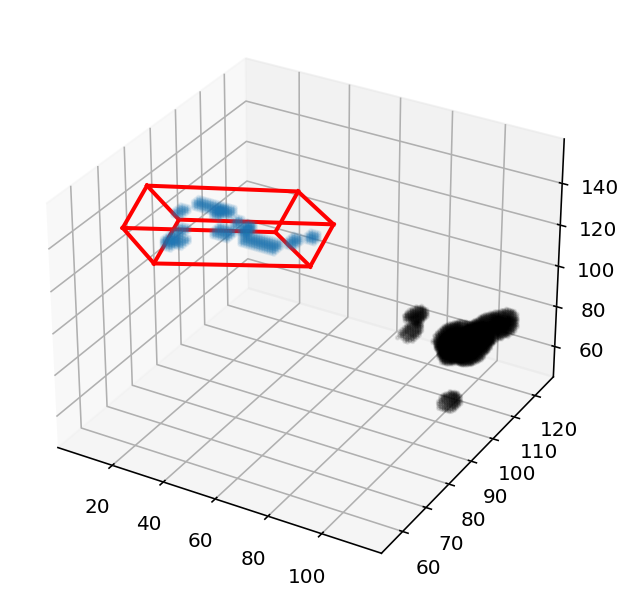

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

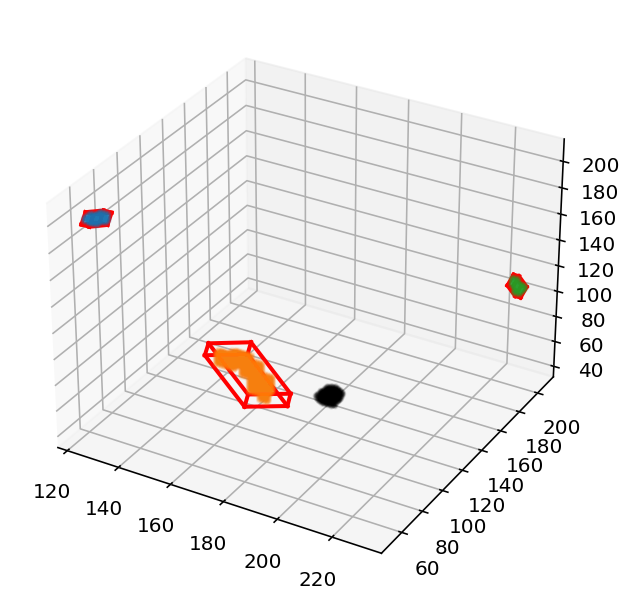

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

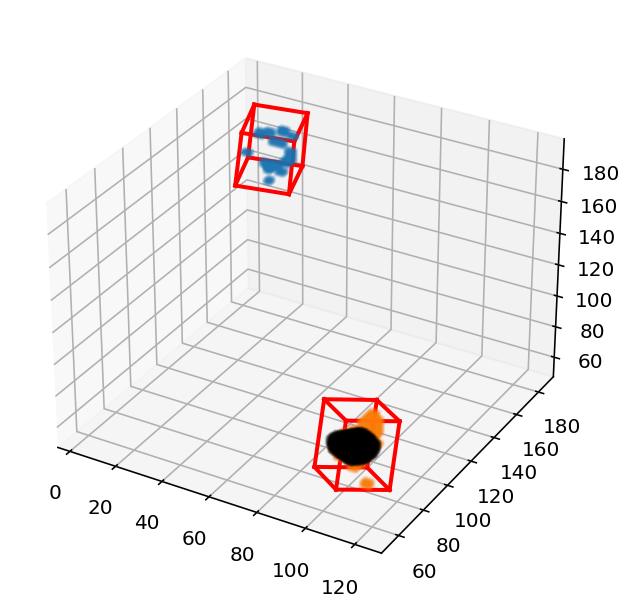

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

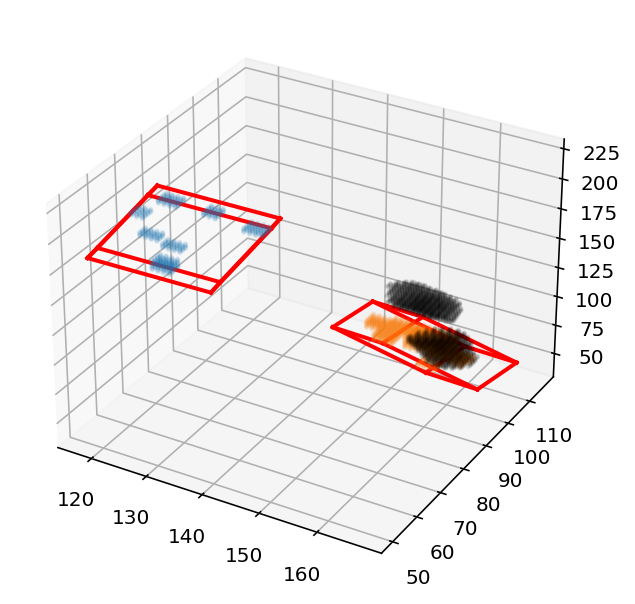

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

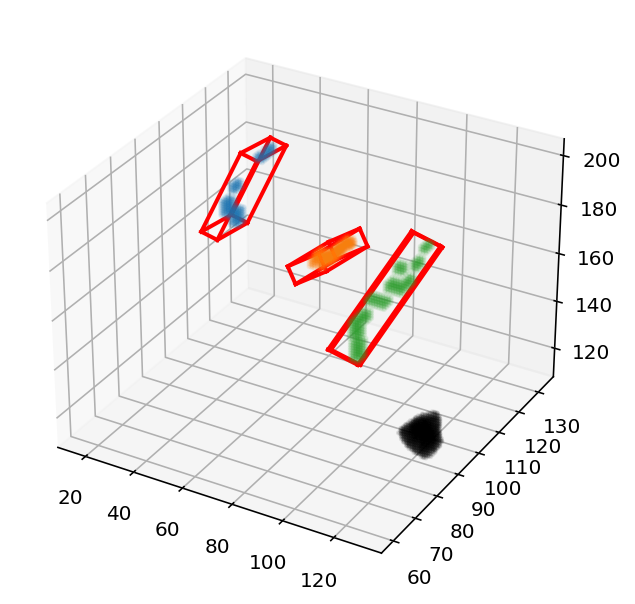

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

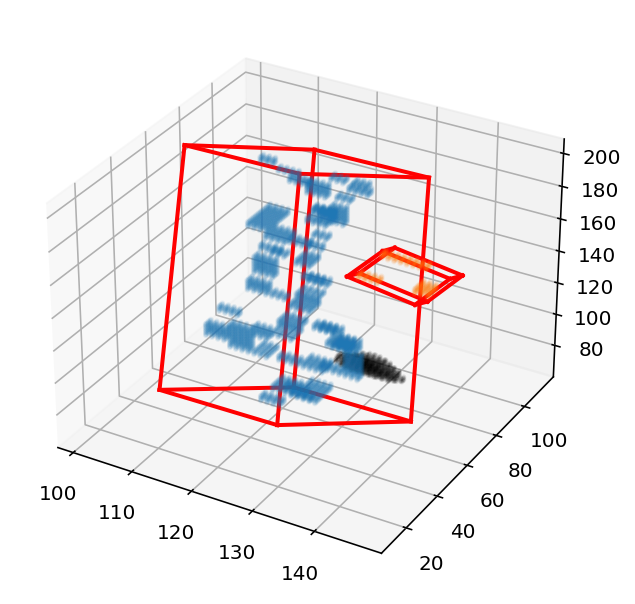

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

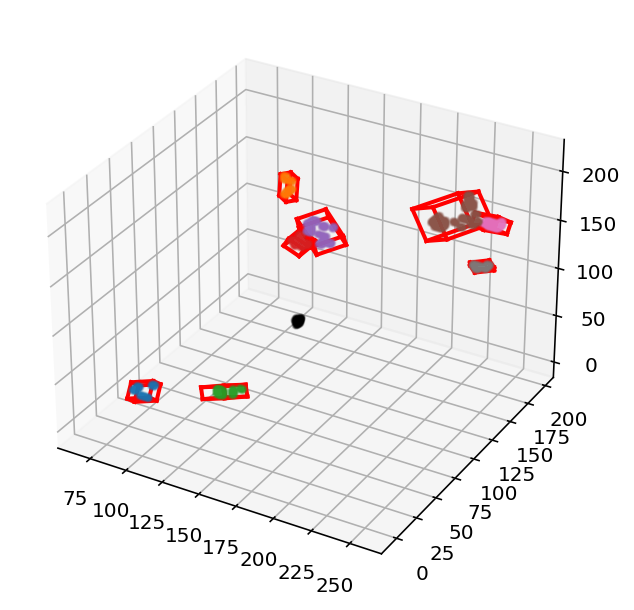

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

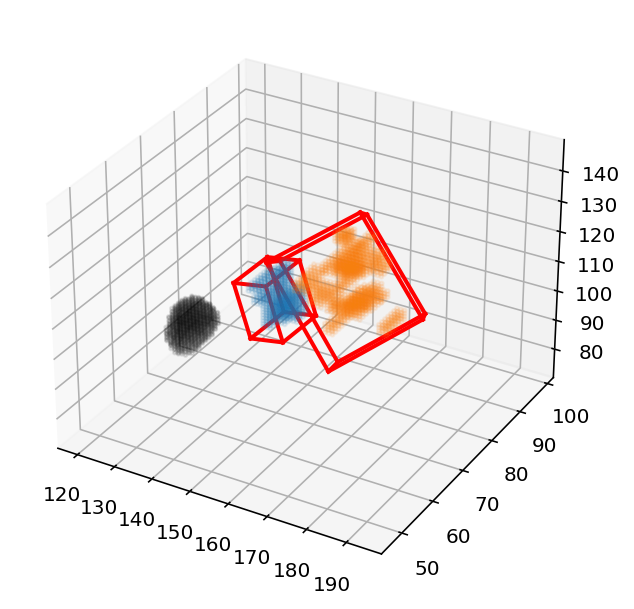

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

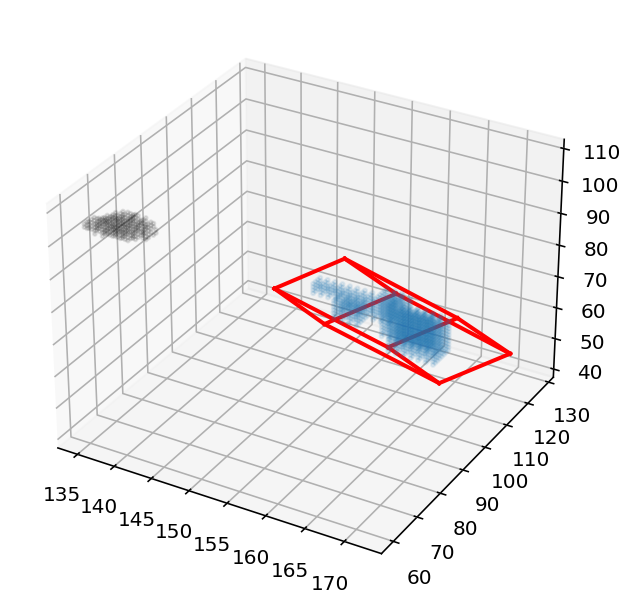

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [23]:
#create bounding box and visualize ground truth masks and outputh masks
candidates = postprocessing.bounding_boxes(processed)
for count,(image,label) in enumerate(zip(processed,labels)):
        fig = plt.figure()
        ax = Axes3D(fig)
        evaluation.draw_mask_3d(label,ax=ax,c="black",alpha=0.1)
        evaluation.draw_mask_3d(image,ax=ax,zorder=10,alpha=0.1,markersize=4)
        evaluation.draw_bounding_box(candidates[count]["candidates"],ax=ax)